In [2]:
%matplotlib widget
import control as ct
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

import hydrostat_cell as hc
import draw_nodes

import importlib

# Individual Cells

Individual cells connect with each other to create one connected "tissue". A cell consists of vertices and muscles (edges).

A cell always maintains a constant volume. Forces act on vertices and any changes in volume are compensated by the free vertices. If a cell is overconstrained, then movement is not possible. 

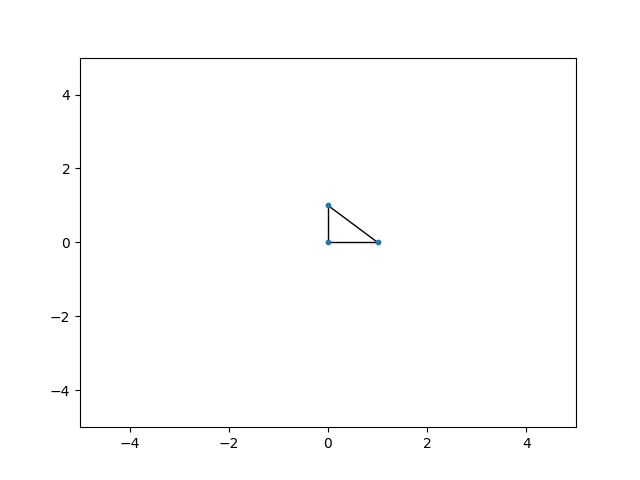

In [3]:
importlib.reload(hc)
importlib.reload(draw_nodes)

cell = hc.HydrostatCell(base=True)
drawer = draw_nodes.NodeDrawer(cell)

In [4]:
# Math scratch
import sympy as sp

# Coordinate Calcs
def wedge_prod(v1, v2):
    return v1[0] * v2[1] - v1[1] * v2[0]

vertices = np.array([
    [.2, 1], 
    [0, 2],
    [3, 3]
])

vec13 = vertices[2] - vertices[0]
vec12 = vertices[1] - vertices[0]
vec23 = vertices[2] - vertices[1]

V1 = 0.5 * wedge_prod(vec13, vec12)
V2 = 0.5 * wedge_prod(vec23, vec12)
V3 = 0.5 * wedge_prod(vec13, vec23)
print(V1, V2, V3)



1.5999999999999999 1.6 -1.6


()
(2, 1001)


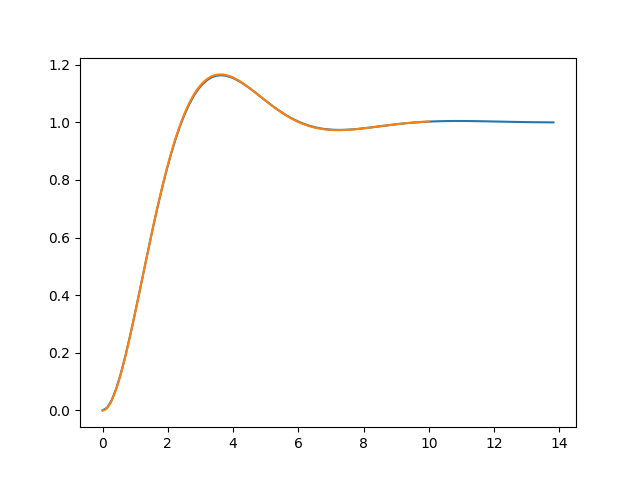

In [23]:
# Comparing continuous dynamics with optimization

m = 1
b = 1
k = 1

A = np.array([[0, 1], [-k/m, -b/m]])
B = np.array([[0], [1/m]])
C = [[1, 0]]
D = [[0]]


sys = ct.ss(A, B, C, D)
t, x = ct.step_response(sys)
fig, ax = plt.subplots()
ax.plot(t, x)

# optimization based simulation

N = 1000  # Number of time steps
delta_t = 0.01  # Time step size
x0 = np.array([0, 0])  # Initial state

# Variables
x = cp.Variable((2, N+1))
u = np.ones((1, N+1))

# Objective function
objective = 0
constraints = [x[:, 0] == x0]

# for idx in range(N):
#     objective += cp.norm(x[:, idx+1] - (x[:, idx] + delta_t * (A @ x[:, idx] + B @ u[:, idx])))

objective = cp.sum(cp.norm(x[:, 1:] - (x[:, :-1] + delta_t * (A @ x[:, :-1] + B @ u[:, :-1])), axis=0))

# Formulate problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve()

# Extract solution
x_values = x.value
print(x_values.shape)
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[0,:])

(4, 1001)
3.5581471738249387e-14


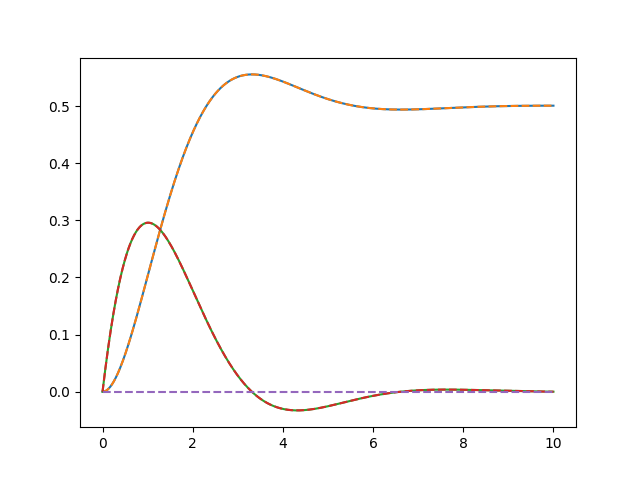

In [33]:
# 1D example with constraints

m1 = 1
m2 = 2
k1 = 1
k2 = 2
k3 = 3
b1 = 1
b2 = 2
b3 = 3
A = np.array([[0, 1, 0, 0],
              [-(k1+k2)/m1, -(b1+b2)/m1, k2/m1, b2/m1],
              [0, 0, 0, 1],
              [k2/m2, b2/m2, -(k2+k3)/m2, -(b2+b3)/m2]])
B = np.array([[0, 0],
              [1/m1, 0],
              [0, 0],
              [0, 1/m2]])
P = np.array([[0],
              [-1/m1],
              [0],
              [1/m2]])

N = 1000  # Number of time steps
delta_t = 0.01  # Time step size
x0 = np.array([0, 0, 0, 0])  # Initial state

# Variables
x = cp.Variable((4, N+1))
p = cp.Variable((1, N+1))
u = np.ones((2, N+1))

# Objective function
objective = 0
constraints = [x[:, 0] == x0, x[1, :] == x[3, :]]
# constraints = [x[:, 0] == x0]

# for idx in range(N):
#     objective += cp.norm(x[:, idx+1] - (x[:, idx] + delta_t * (A @ x[:, idx] + B @ u[:, idx] + P @ p[:, idx])))

objective = cp.sum(cp.norm(x[:, 1:] - (x[:, :-1] + delta_t * (A @ x[:, :-1] + B @ u[:, :-1] + P @ p[:, :-1])), axis=0))

# Formulate problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve()

# Extract solution
x_values = x.value
print(x_values.shape)
print(problem.objective.value)
fig, ax = plt.subplots()
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[0,:])
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[2,:], "--")
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[1,:])
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[3,:], "--")
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[2,:] - x_values[0,:], "--")

In [34]:

# 1D example with constraints
A = np.array([[0, 1],
              [-(k1+k3)/(m1+m2), -(b1+b3)/(m1+m2)]])
B = np.array([[0, 0],
              [1/(m1+m2), 1/(m1+m2)]])

N = 1000  # Number of time steps
delta_t = 0.01  # Time step size
x0 = np.array([0, 0])  # Initial state

# Variables
x = cp.Variable((2, N+1))
u = np.ones((2, N+1))

# Objective function
objective = 0
# constraints = [x[:, 0] == x0]
dynamic_constraint = x[:, 1:] == x[:, :-1] + delta_t * (A @ x[:, :-1] + B @ u[:, :-1])
constraints = [
    x[:, 0] == x0,
    dynamic_constraint
]

# for idx in range(N):
#     objective += cp.norm(x[:, idx+1] - (x[:, idx] + delta_t * (A @ x[:, idx] + B @ u[:, idx])))**2

# objective = cp.sum(cp.norm(x[:, 1:] - (x[:, :-1] + delta_t * (A @ x[:, :-1] + B @ u[:, :-1])), axis=0))

# Formulate problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve()

# Extract solution
x_values = x.value
print(x_values.shape)
print(problem.objective.value)
# fig, ax = plt.subplots()
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[0,:], "k--")
ax.plot(np.arange(0, (N+1)*delta_t, delta_t)[:N+1], x_values[1,:], "k--")

(2, 1001)
0.0


In [48]:
# Test bed for 2D

rotor_deg = lambda x: np.array([
    [np.cos(np.deg2rad(x)), -np.sin(np.deg2rad(x))],
    [np.sin(np.deg2rad(x)), np.cos(np.deg2rad(x))]
])

# Define Simulation Parameters
tf = 10 # final time
dt = 0.1 # time step
t = np.arange(0, tf, dt)
simulation_steps = len(t)

# Define System Parameters
damping_ratio = 1.1
k = 1
m = 1
b = damping_ratio * 2 * (m*k)**0.5

x0 = [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

double_area = (x0[4] - x0[0]) * (x0[3] - x0[1]) + (x0[5] - x0[1]) * (x0[2] - x0[0])

# Define Variables
x = cp.Variable((len(x0), simulation_steps))
u = np.zeros((9, simulation_steps)) # F1x, F1y, F2x, F2y, F3x, F3y, f12, f23, f31
u[4, :] = np.ones(simulation_steps)
u[5, :] = np.ones(simulation_steps)

# edge_vectors = np.array([
#     [x[2] - x[0], x[4] - x[2], x[0] - x[4]],
#     [x[3] - x[1], x[5] - x[3], x[1] - x[5]]
# ])
# print(edge_vectors.shape)
# edge_magnitudes = np.linalg.norm(edge_vectors, axis=0)
# unit_edge_vectors = edge_vectors / edge_magnitudes


# Define Constraints
continuity_constraint = (cp.multiply((2 * x[1] - x[3] - x[5]), x[6])
                         + cp.multiply((2*x[0] - x[2] - x[4]), x[7])
                         + cp.multiply((x[5] - x[1]), x[8])
                         + cp.multiply((x[4] - x[0]), x[9])
                         + cp.multiply((x[3] - x[1]), x[10])
                         + cp.multiply((x[2] - x[0]), x[11])
                         == np.zeros(simulation_steps))

area_constraint = (
    (x[4] - x[0]) * (x[3] - x[1]) + (x[5] - x[1]) * (x[2] - x[0]) == double_area
)

print(continuity_constraint.is_dqcp())
f = 0

dynamic_constraint = (
    x[:, 1:] == (x[:, :-1] + dt * f)
)

constraints = [
    x[:, 0] == x0,
    continuity_constraint,
    # dynamic_constraint
]

objective = 0

# Solve problem
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

x_values = x.value
print(x_values.shape)
print(problem.objective.value)

False


c:\Users\Alex\Documents\_projTech\030_isochoric\venv\Lib\site-packages\cvxpy\expressions\expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 23 times so far.

  warnings.warn(msg, UserWarning)
c:\Users\Alex\Documents\_projTech\030_isochoric\venv\Lib\site-packages\cvxpy\expressions\expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so fa

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
(Promote(2.0, (100,)) @ var58016[1, 0:100] + -var58016[3, 0:100] + -var58016[5, 0:100]) @ var58016[6, 0:100] + (Promote(2.0, (100,)) @ var58016[0, 0:100] + -var58016[2, 0:100] + -var58016[4, 0:100]) @ var58016[7, 0:100] + (var58016[5, 0:100] + -var58016[1, 0:100]) @ var58016[8, 0:100] + (var58016[4, 0:100] + -var58016[0, 0:100]) @ var58016[9, 0:100] + (var58016[3, 0:100] + -var58016[1, 0:100]) @ var58016[10, 0:100] + (var58016[2, 0:100] + -var58016[0, 0:100]) @ var58016[11, 0:100] == [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] , because the following subexpressions are not:
|--  (Promote(2.0, (100,)) @ var58016[1, 0:100] + -var58016[3, 0:100] + -var58016[5, 0:100]) @ var58016[6, 0:100]
|--  (Promote(2.0, (100,)) @ var58016[0, 0:100] + -var58016[2, 0:100] + -var58016[4, 0:100]) @ var58016[7, 0:100]
|--  (var58016[5, 0:100] + -var58016[1, 0:100]) @ var58016[8, 0:100]
|--  (var58016[4, 0:100] + -var58016[0, 0:100]) @ var58016[9, 0:100]
|--  (var58016[3, 0:100] + -var58016[1, 0:100]) @ var58016[10, 0:100]
|--  (var58016[2, 0:100] + -var58016[0, 0:100]) @ var58016[11, 0:100]